# Papers with Code: Unsupervised Seismic Waveform Classificatio

## 2.5D Synthetic:

 This notebook demonstrates a complete workflow for unsupervised seismic waveform classification. In simple terms, we will:
   1. Create a synthetic geological model of a meandering river channel.
   2. Generate synthetic seismic data from this model, simulating a seismic survey.
   3. Use a machine learning algorithm (K-Means clustering) to automatically group the seismic traces into different "seismic facies" based on their
      waveform shape.
   4. Analyze and visualize the results to see if the machine learning algorithm successfully identified our channel system.

---

First, we need to import all the necessary Python libraries, which are like toolkits for specific jobs.
* **NumPy**: is the fundamental package for numerical computing in Python. We use it to create and manipulate our multi-dimensional seismic data arrays.
* **Matplotlib**: is the primary library for creating plots and visualizations. We'll use it to display seismic sections,
* **Scikit-learn**: is a powerful machine learning library. We import KMeans, the specific algorithm we'll use to perform the clustering.
* Specifically from the sklearn library we import the **silhouette_score**, which is a function used to evaluate how well our clustering algorithm performed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In order to build our synthetic geological model (meandering channel), we need to define some geological parameters. The user can vary these values to create different channel geometries.
* `center_row` and `thickness`: Control the vertical position and thickness of the channel.
* `center_offset`and `max_shift`: Control the overall position and how much the channel "meanders" from side to side.
* `n_cycles` and `phase_rad`: These define the sinuosity of the channel, controlling the number of meanders and their starting position.

In [ ]:
center_row      = 3     # vertical position of the channel’s mid-line
thickness       = 10      # 1 = single row; 3,5… = wider channel (odd numbers look nicest)
center_offset   = 4      # constant lateral shift (columns); use to centre L↔R, e.g. -1, 0, +1
max_shift       = 4      # half-swing left/right ( ≥0 and ≤ cols-len(base_rc_values) )
n_cycles        = 1      # number of full meanders from top slice to bottom slice
phase_rad       = 0      # starting phase in radians (slide the whole sine curve sideways)
# ------------------------------------------------------------------

Additionally, we need to defines the overall dimensions of our 2.5D model. For that we define:
* `rows` and `cols`: The size of each 2D slice (7 rows x 10 columns). Think of this as the dimensions of a single vertical cross-section.
* `required_slices`: The number of slices in our 2.5D volume (25). This adds the third dimension to our model.

In [ ]:
# Geometry
rows, cols        = 7, 10      # size of each cross-section
required_slices   = 25   

In order to initialize the model and define the main channel in the geological model we first create an empty 3D "box" (defining a NumPy array filled with zeros) called `rc_3d_extended` to hold our model. Then, we define `base_rc_values`. This array represents the Reflection Coefficients (RC) of our channel. The pattern `[0.25, 0.7, 1, 0.7, 0.25, ...]` is the seismic "signature" of the channel itself, with the highest reflectivity at the center.

In [ ]:
# Rebuild the 2.5D RC volume
rc_3d_extended = np.zeros((required_slices, rows, cols))

In [ ]:
# Base RC pattern that represents the channel in one slice
base_rc_values = np.array([0.25, 0.7, 1, 0.7, 0.25, 0, 0, 0, 0, 0])

The next is the core logic for building the 3D model, since it creates the meandering channel by looping through each of the 25 slices. Inside the loop, it calculates a `shift_val` using a sine wave. This value determines how far to shift the channel left or right on that specific slice, creating the meandering effect. The `np.roll()` function takes the `base_rc_values` (our channel signature) and shifts it into the correct lateral position for that slice. This process is repeated for every slice, building the full 3D meandering channel system.

In [ ]:
for i in range(required_slices):

    # Lateral shift follows a sine wave + a fixed offset to centre/honour user choice
    shift_val = int(
        np.round(center_offset +
                 max_shift * np.sin(2 * np.pi * n_cycles * i / required_slices + phase_rad))
    )

    # --------------------------------------------------------------
    # Write the channel into one (or several) rows to control width
    # --------------------------------------------------------------
    half = thickness // 2            # how many rows up/down from the centre_row
    for dr in range(-half, half + 1):
        r = center_row + dr
        if 0 <= r < rows:            # stay inside the volume
            rc_3d_extended[i, r, :] = np.roll(base_rc_values, shift=shift_val)

These cells are for data cleanup. They ensure the final 3D reflection coefficient model (rc_3d_extended) has exactly 25 slices.

In [ ]:
# --------------------------------------------------
# Legacy variables — retained so the rest of the notebook runs
rc_3d          = rc_3d_extended.copy()   # original 3-D volume name
rc_3d_mirrored = rc_3d_extended[::-1]    # still available if referenced later
sequences      = 1                       # placeholder (no longer used)
# --------------------------------------------------

In [ ]:
rc_3d_extended = np.concatenate(
    [rc_3d if i % 2 == 0 else rc_3d_mirrored for i in range(sequences)],
    axis=0,
)

In [ ]:
# Trim or add slices to reach exactly 25
required_slices = 25
current_slices = rc_3d_extended.shape[0]
if current_slices > required_slices:
    rc_3d_extended = rc_3d_extended[:required_slices]
elif current_slices < required_slices:
    # Repeat last slice to match required slices
    rc_3d_extended = np.concatenate(
        [
            rc_3d_extended,
            np.repeat(
                rc_3d_extended[-1][np.newaxis, :, :],
                required_slices - current_slices,
                axis=0,
            ),
        ],
        axis=0,
    )

Next cell prints the final shape of our RC model, which is the original parameters should be `(25, 7, 10)`, which means 25 slices, each with 7 rows and 10 columns.

In [ ]:
# Display the new array dimensions
print("Extended rc_3d shape:", rc_3d_extended.shape)

Extended rc_3d shape: (25, 7, 10)


Now, we want to visualize the geology we just created. For this, the following code extracts a horizontal slice (a "map view") from our 3D model and uses `plt.imshow()` to display it as an image. The resulting plot clearly shows the meandering path of the channel at a specific depth (the 3rd row).

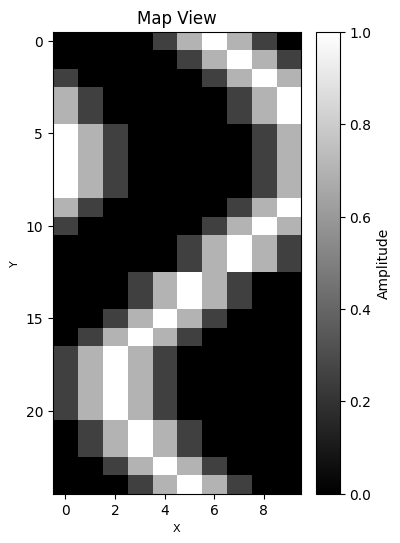

In [ ]:
# Plot the map view of the 3rd row
map_view = rc_3d_extended[:, 3, :]  # Extract the 3rd row from all slices

plt.figure(figsize=(4, 6))
plt.imshow(map_view, cmap="grey", aspect="auto")
plt.title("Map View", fontsize=12)
plt.xlabel("X", fontsize=8)
plt.ylabel("Y", fontsize=8)
plt.colorbar(label="Amplitude")
plt.show()

To create a synthetic seismogram, we need a source wavelet. For that, in the next cells of code we define and plot a synthetic Ricker Wavelet. This is the "pulse" of sound that a seismic source would generate. First we need to define the parameters for a Ricker wavelet.

In [ ]:
# Define parameters
freq = 100
tn = 100
dt = 1

In [ ]:
# Create time array
t = np.arange(-tn / 2, tn / 2 + dt, dt) / 1000

In [ ]:
# Define Ricker Wavelet
ricker = (1 - 2 * np.pi**2 * freq**2 * t**2) * np.exp(-np.pi**2 * freq**2 * t**2)

And now, with the following code we plot the Ricker wavelet.

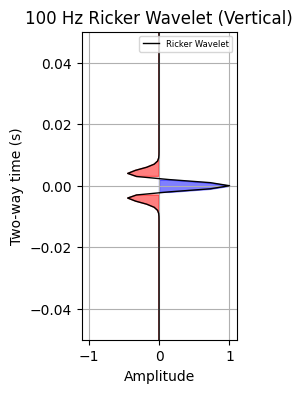

In [ ]:
# Plot Ricker wavelet (Vertical)
plt.figure(figsize=(2, 4))
plt.plot(ricker, t, lw=1, color='black', label='Ricker Wavelet')
plt.fill_betweenx(t, ricker, 0, ricker > 0.0, color='blue', alpha=0.5)
plt.fill_betweenx(t, ricker, 0, ricker < 0.0, color='red', alpha=0.5)
plt.title('%d Hz Ricker Wavelet (Vertical)' % freq, fontsize=12)
plt.xlabel('Amplitude', fontsize=10)
plt.ylabel('Two-way time (s)', fontsize=10)
plt.xlim((-1.1, 1.1))
plt.ylim((min(t), max(t)))
plt.grid()
plt.legend(fontsize = 6, loc = 'upper right')
plt.show()

Then, we need to convolve the reflection coefficient with the waveet to create the seismic traces. For that, we create a new empty 3D array, `synth_seismic`, to hold the results. Then, the code then loops through every vertical column of our RC model. For each column, it performs a convolution (using the `np.convolve` function) between the Ricker wavelet and the reflection coefficients. The output is a 3D volume of seismic amplitude data.

In [ ]:
# Initialize an array for synthetic seismic
synth_seismic = np.zeros((len(t), rc_3d_extended.shape[0], rc_3d_extended.shape[2]))

In [ ]:
# Perform convolution for each slice and each column
for slice_idx in range(rc_3d_extended.shape[0]):
    for col_idx in range(rc_3d_extended.shape[2]):
        # Convolve the Ricker wavelet with the column data
        synth_seismic[:, slice_idx, col_idx] = np.convolve(
            rc_3d_extended[slice_idx, :, col_idx], ricker, mode="same"
        )

# Display the dimensions of the synthetic seismic array
print(f"Synthetic seismic shape: {synth_seismic.shape}")

Synthetic seismic shape: (101, 25, 10)


In [ ]:
synth_seismic.shape[0]

101

Since real-world seismic data is never perfect; it always contains random noise. In the following code we add a small amount of random noise to our clean synthetic data to make the classification task more realistic and challenging. Since this is a educational tutorial, with the `np.random.seed(42)` function we ensure that the "random" noise is the same every time you run the code, making the results reproducible. 

In [ ]:
# Add random noise to the synthetic seismic data
np.random.seed(42)
noise = np.random.normal(0, 0.1, synth_seismic.shape)
synth_seismic_noisy = synth_seismic + noise
# Set slice_to_visualize to a valid index in the slice dimension
slice_to_visualize = synth_seismic.shape[1] // 2  # Middle slice (index 12 for 25 slices)

Now, to visualize the generated synthetic seismic data, before classification, we proceed to plot a vertical seismic section. It shows two views: one with raw pixels ("No Interpolation") and one that is smoothed ("Quadric Interpolation"), which is how data is often displayed in interpretation software.

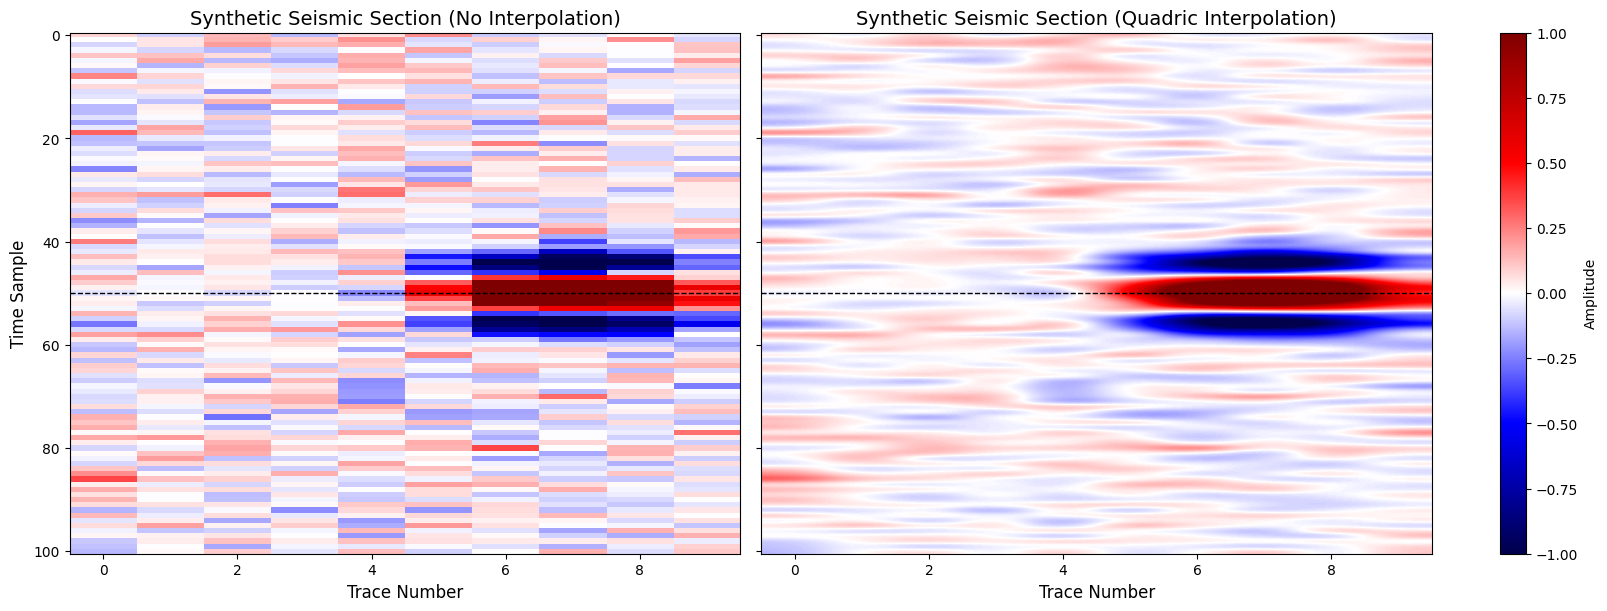

In [ ]:
# Visualize the selected slice with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True, sharey=True)

# Plot without interpolation (Left)
axs[0].imshow(synth_seismic_noisy[:, slice_to_visualize, :], cmap="seismic", aspect="auto", interpolation="none", vmin=-1, vmax=1)
axs[0].set_title(f"Synthetic Seismic Section (No Interpolation)", fontsize=14)
axs[0].set_xlabel("Trace Number", fontsize=12)
axs[0].set_ylabel("Time Sample", fontsize=12)
axs[0].axhline(y=synth_seismic.shape[0]//2, color='black', linestyle='--', lw=1)

# Plot with interpolation (Right)
im = axs[1].imshow(synth_seismic_noisy[:, slice_to_visualize, :], cmap="seismic", aspect="auto", interpolation="quadric", vmin=-1, vmax=1)
axs[1].set_title(f"Synthetic Seismic Section (Quadric Interpolation)", fontsize=14)
axs[1].set_xlabel("Trace Number", fontsize=12)
axs[1].axhline(y=synth_seismic.shape[0]//2, color='black', linestyle='--', lw=1)

# Add a single colorbar for both plots
cbar = fig.colorbar(im, ax=axs, orientation="vertical", label="Amplitude")

plt.show()

Additionally, in case we would like to plot a horizontal time-slice (map view), we can use the following code. This shows the seismic response of our channel system as it would appear on a map at a specific travel time. Dashed green line represents the location of the previously displayed vertical seismic section.

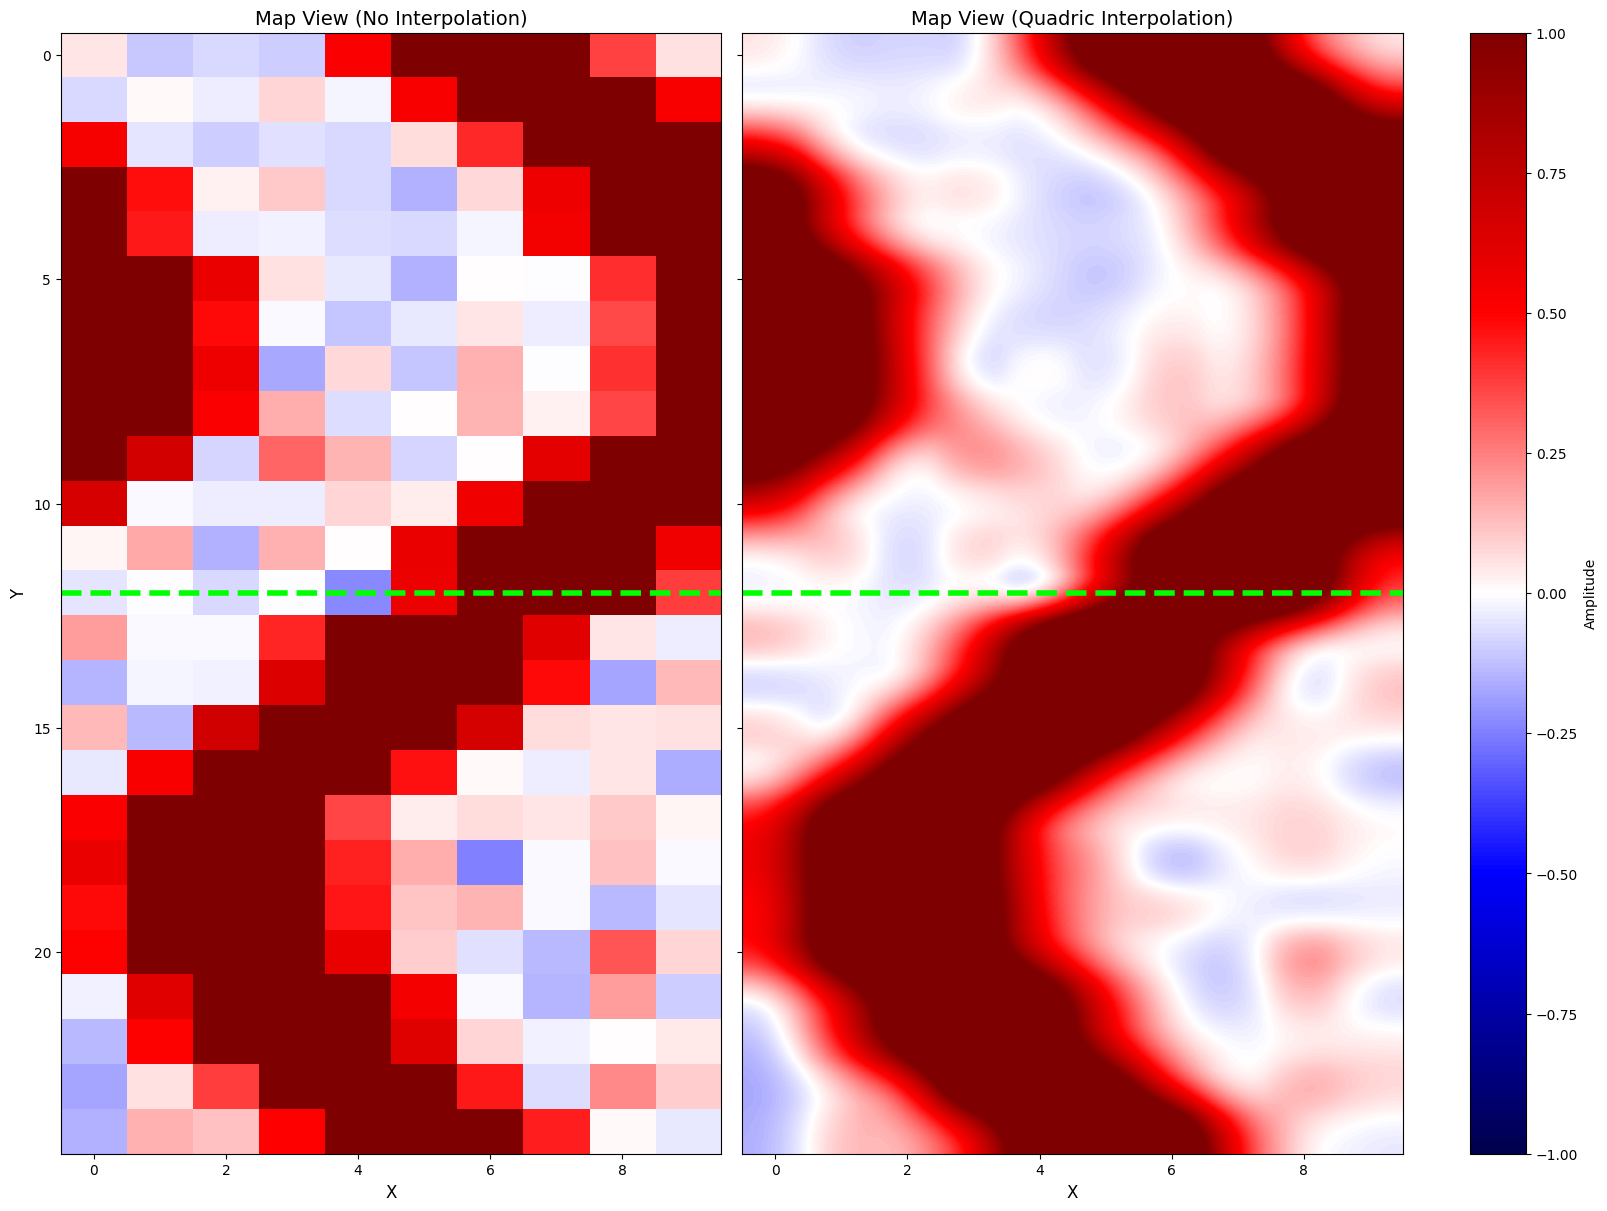

In [ ]:
# Define the time sample to visualize in the map view
time_sample = len(t) // 2  # Choose the center of the Ricker wavelet

# Extract the selected time sample across all slices and traces
map_view = synth_seismic_noisy[time_sample, :, :]

# Plot the map view with two subplots for comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 12), constrained_layout=True, sharey=True)

# Plot without interpolation (Left)
axs[0].imshow(map_view, cmap="seismic", aspect="auto", vmin=-1, vmax=1, interpolation="none")
axs[0].set_title("Map View (No Interpolation)", fontsize=14)
axs[0].set_xlabel("X", fontsize=12)
axs[0].set_ylabel("Y", fontsize=12)
axs[0].axhline(y=12, color='lime', linestyle='--', lw = 4)  # Add dashed horizontal line at y = 12

# Plot with interpolation (Right)
im = axs[1].imshow(map_view, cmap="seismic", aspect="auto", vmin=-1, vmax=1, interpolation="quadric")
axs[1].set_title("Map View (Quadric Interpolation)", fontsize=14)
axs[1].set_xlabel("X", fontsize=12)
axs[1].axhline(y=12, color='lime', linestyle='--', lw = 4)  # Add dashed horizontal line at y = 12

# Add a single colorbar for both plots
cbar = fig.colorbar(im, ax=axs, orientation="vertical", label="Amplitude")

plt.show()

---

### Unsupervised Classification (K-Means Clustering)

Since the *K-Means* algorithm expects a 2D table where each row is a single item to be classified. Our seismic data is a 3D cube. This code "flattens" our data. It treats each full seismic trace (a 1D array of amplitudes over time) as a single data point. The result is a 2D array where each row is a trace.

In [ ]:
# Reshape `synth_seismic_noisy` for clustering
time_samples, slices, traces = synth_seismic_noisy.shape
synth_seismic_noisy_flat = synth_seismic_noisy.reshape(time_samples, slices * traces).T  # Shape: (slices * traces, time_samples)

Here is where the automatic classification happens. To run the K-Means algorithm we use the parameter `num_clusters = 4`, meaning that we tell the algorithm that we want to find 4 distinct groups of wavelets in our data. The function `kmeans.fit_predict()` generate the prediction, since the algorithm analyzes the shape of every trace and assigns it to one of the 4 clusters. The output, `cluster_labels`, is a list of which cluster each trace belongs to.

In [ ]:
# Number of clusters for k-Means
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(synth_seismic_noisy_flat)  # Assign cluster labels to each trace

To visualize the clustering output, in this case the geographic distribution of the classified facies with the following code we reshape the `cluster_labels` back into a 2D map. The `imshow` plot allow us to plot the final classification map. In this image, each color represents a different seismic facies found by the algorithm. In general, the pattern of colors should outline our meandering channel.

In [ ]:
# Reshape cluster labels back to the original seismic structure
cluster_labels_reshaped = cluster_labels.reshape(slices, traces)

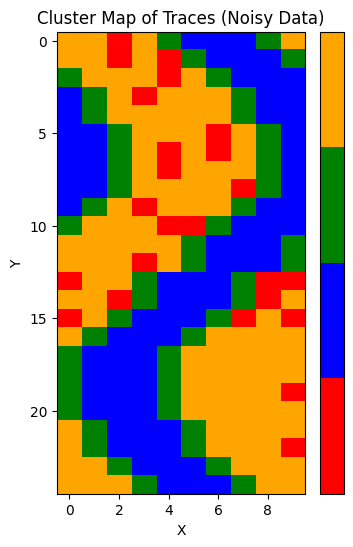

In [ ]:
# Visualize the clustering results as a map
plt.figure(figsize=(4, 6))
plt.imshow(cluster_labels_reshaped, cmap=ListedColormap(['red', 'blue', 'green', 'orange']), aspect="auto")

# Add a colorbar without ticks or label
cbar = plt.colorbar()
cbar.set_ticks([])  # Remove the ticks
cbar.set_label("")  # Remove the label

# Add titles and labels
plt.title("Cluster Map of Traces (Noisy Data)", fontsize=12)
plt.xlabel("X", fontsize=10)
plt.ylabel("Y", fontsize=10)
plt.show()

C:\Users\Windows\AppData\Local\Temp\ipykernel_33604\686742632.py:21: UserWarning: Adding colorbar to a different Figure <Figure size 1600x1200 with 3 Axes> than <Figure size 1600x1200 with 3 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axs, orientation="vertical", label="Amplitude")


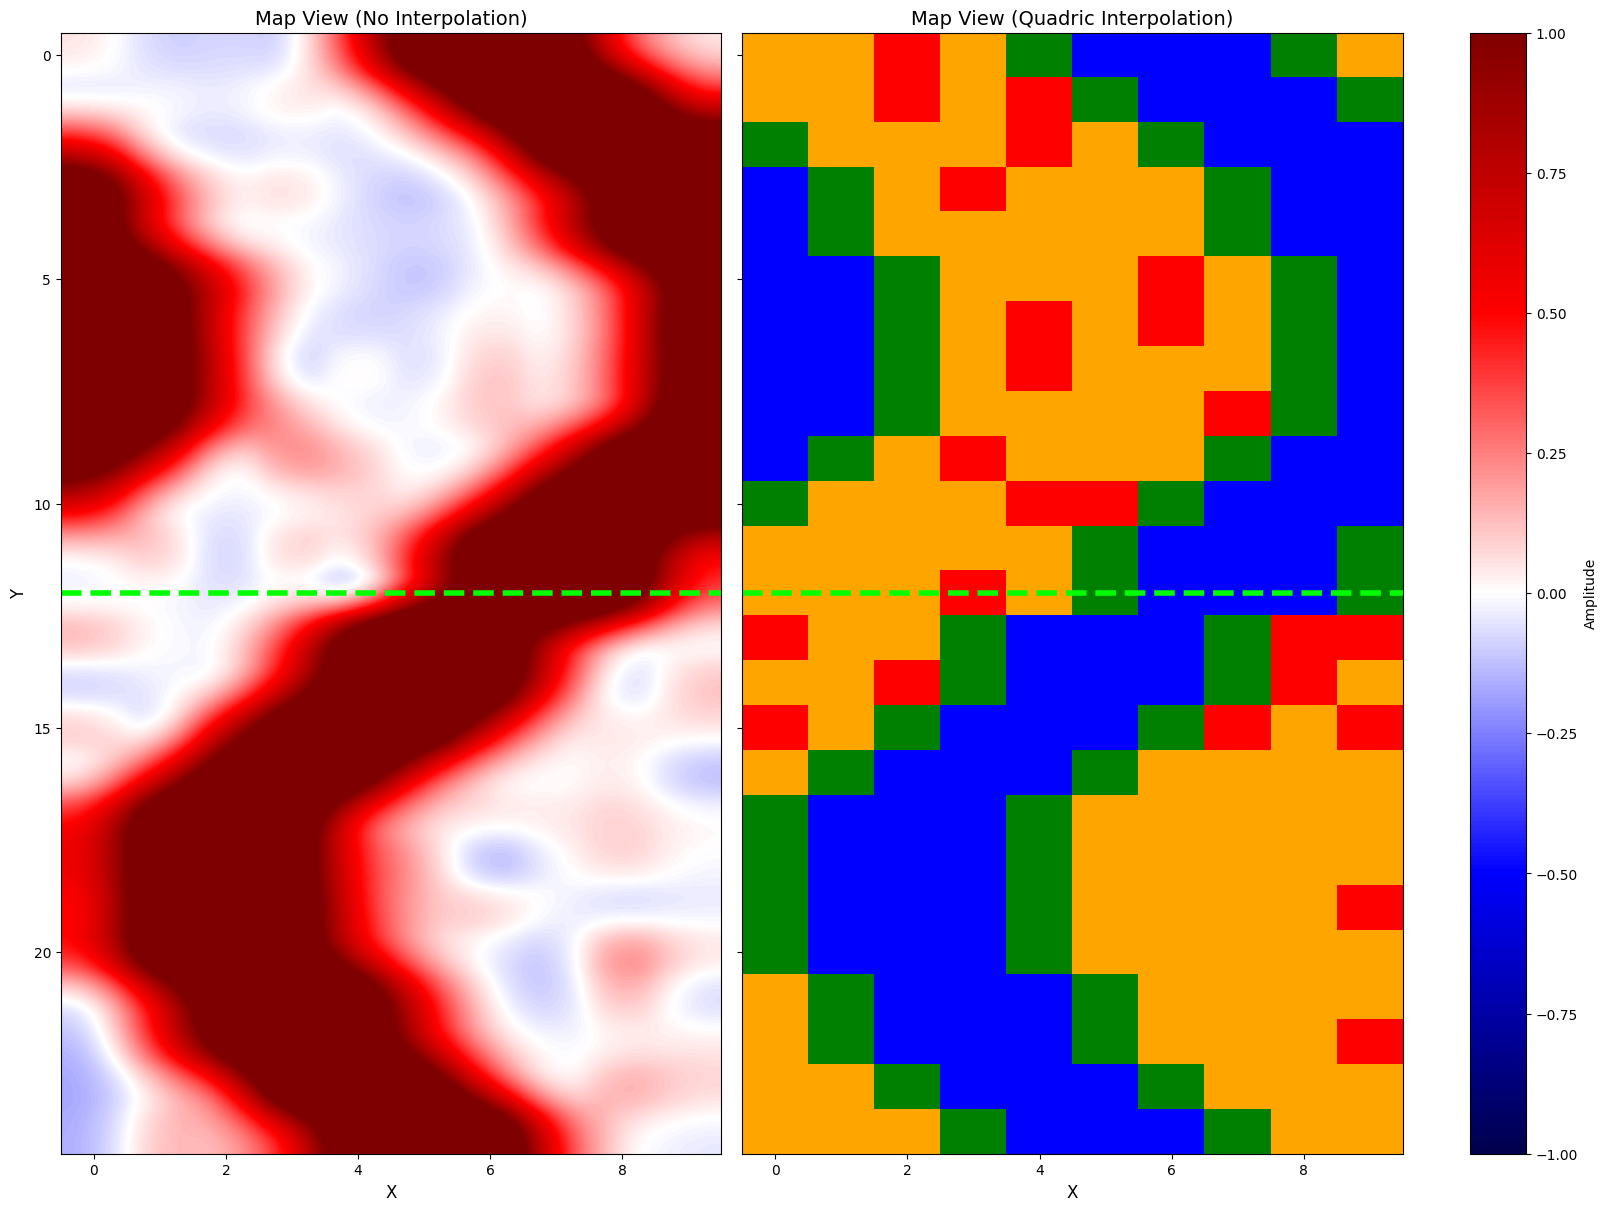

In [ ]:
# Define the time sample to visualize in the map view
time_sample = len(t) // 2  # Choose the center of the Ricker wavelet

# Plot the map view with two subplots for comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 12), constrained_layout=True, sharey=True)

# Plot without interpolation (Left)
axs[0].imshow(synth_seismic_noisy[time_sample, :, :], cmap="seismic", aspect="auto", vmin=-1, vmax=1, interpolation="quadric")
axs[0].set_title("Map View (No Interpolation)", fontsize=14)
axs[0].set_xlabel("X", fontsize=12)
axs[0].set_ylabel("Y", fontsize=12)
axs[0].axhline(y=12, color='lime', linestyle='--', lw = 4)  # Add dashed horizontal line at y = 12

# Plot with interpolation (Right)
axs[1].imshow(cluster_labels.reshape(slices, traces), ListedColormap(['red', 'blue', 'green', 'orange']), aspect="auto")
axs[1].set_title("Map View (Quadric Interpolation)", fontsize=14)
axs[1].set_xlabel("X", fontsize=12)
axs[1].axhline(y=12, color='lime', linestyle='--', lw = 4)  # Add dashed horizontal line at y = 12

# Add a single colorbar for both plots
cbar = fig.colorbar(im, ax=axs, orientation="vertical", label="Amplitude")

plt.show()

Now, we can generate a diagnostic plot, which brings everything together for a single seismic line. On the feft Panel, we can see the original seismic data. Middle Panel shows the cluster classification for each trace on that line. The right panel is an overlay of the clusters on the seismic data, making it easy to see which waveforms correspond to which facies.

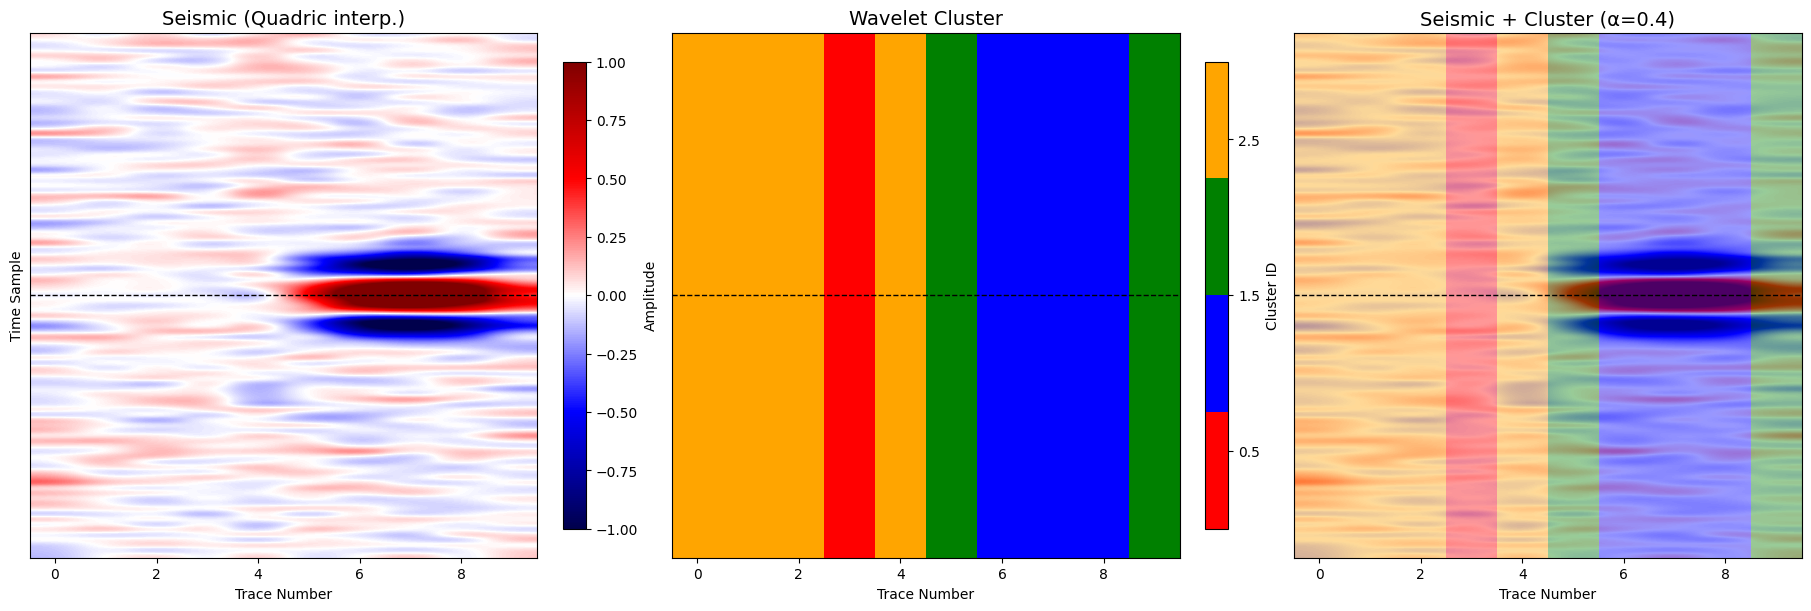

In [ ]:
# ---------------------------------------------------------------
# three‑panel view: seismic + clusters + overlay
# ---------------------------------------------------------------
slice_to_visualize = synth_seismic.shape[1] // 2              # same as before

seis_quad = synth_seismic_noisy[:, slice_to_visualize, :]     # (time, trace)
cl_row    = cluster_labels_reshaped[slice_to_visualize, :]    # (trace,)

cluster_cmap = ListedColormap(['red', 'blue', 'green', 'orange'])

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True,
                       constrained_layout=True)

# 1) seismic with quadric interpolation -----------------------------------
im0 = ax[0].imshow(seis_quad, cmap='seismic', aspect='auto',
                   interpolation='quadric', vmin=-1, vmax=1)
ax[0].set_title('Seismic (Quadric interp.)', fontsize=14)
ax[0].set_xlabel('Trace Number')
ax[0].set_ylabel('Time Sample')
ax[0].axhline(y=synth_seismic.shape[0]//2, color='black', ls='--', lw=1)

# 2) cluster strip --------------------------------------------------------
# turn the 1‑D class array into a 2‑D image by tiling rows
cluster_img = np.tile(cl_row, (seis_quad.shape[0], 1))
im1 = ax[1].imshow(cluster_img, cmap=cluster_cmap, aspect='auto',
                   interpolation='nearest')
ax[1].set_title('Wavelet Cluster', fontsize=14)
ax[1].set_xlabel('Trace Number')
ax[1].axhline(y=synth_seismic.shape[0]//2, color='black', ls='--', lw=1)

# remove y‑tick labels on the middle panel (shared)
ax[1].set_yticks([])

# 3) overlay --------------------------------------------------------------
im2 = ax[2].imshow(seis_quad, cmap='seismic', aspect='auto',
                   interpolation='quadric', vmin=-1, vmax=1)
ax[2].imshow(cluster_img, cmap=cluster_cmap, aspect='auto',
             interpolation='nearest', alpha=0.4)
ax[2].set_title('Seismic + Cluster (α=0.4)', fontsize=14)
ax[2].set_xlabel('Trace Number')
ax[2].axhline(y=synth_seismic.shape[0]//2, color='black', ls='--', lw=1)
ax[2].set_yticks([])

# colour‑bars -------------------------------------------------------------
cbar_amp = fig.colorbar(im0, ax=ax[0], fraction=0.046, label='Amplitude')
cbar_cls = fig.colorbar(im1, ax=ax[1], fraction=0.046,
                        ticks=np.arange(len(cluster_cmap.colors))+0.5)
cbar_cls.ax.set_ylabel('Cluster ID')

plt.show()


However, how do we know k=4 was the right number of clusters? The Elbow Method helps justify this choice. The code runs K-Means multiple times with different numbers of clusters (from 2 to 10) and calculates a score (SSE - Sum of Squared Errors) for each. The plot shows that the benefit of adding more clusters drops off sharply after 3 or 4. This "elbow" in the curve suggests that 4 is a reasonable number of clusters for this dataset.

In [ ]:
# Elbow method and silhouette scores for optimal cluster number
sse = []  # Sum of Squared Errors
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(synth_seismic_noisy_flat)
    sse.append(kmeans.inertia_)

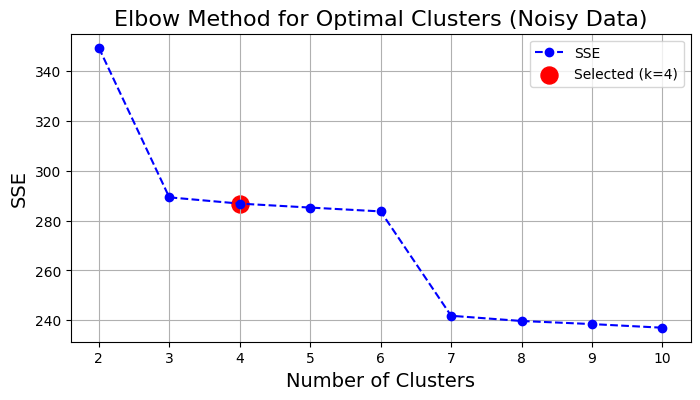

In [ ]:
# Plot elbow method
plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker="o", linestyle="--", color="blue", label="SSE")
plt.scatter(num_clusters, sse[num_clusters - 2], color="red", s=150, label=f"Selected (k={num_clusters})")
plt.title("Elbow Method for Optimal Clusters (Noisy Data)", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("SSE", fontsize=14)
plt.grid()
plt.legend()
plt.show()

Finally, in order to understand what each classified facies looks like in terms of its seismic response, we can plot the average waveforms for each cluster
With the next code, we can groups all the traces belonging to each of the 4 clusters. It then calculates and plots the average waveform for each cluster. This is a crucial QC step. You can now look at the four plots and give them geological meaning. For example, "Cluster 1" might have a high-amplitude
peak-trough response characteristic of the channel axis, while "Cluster 3" might have a low-amplitude, noisy response characteristic of the surrounding floodplain.

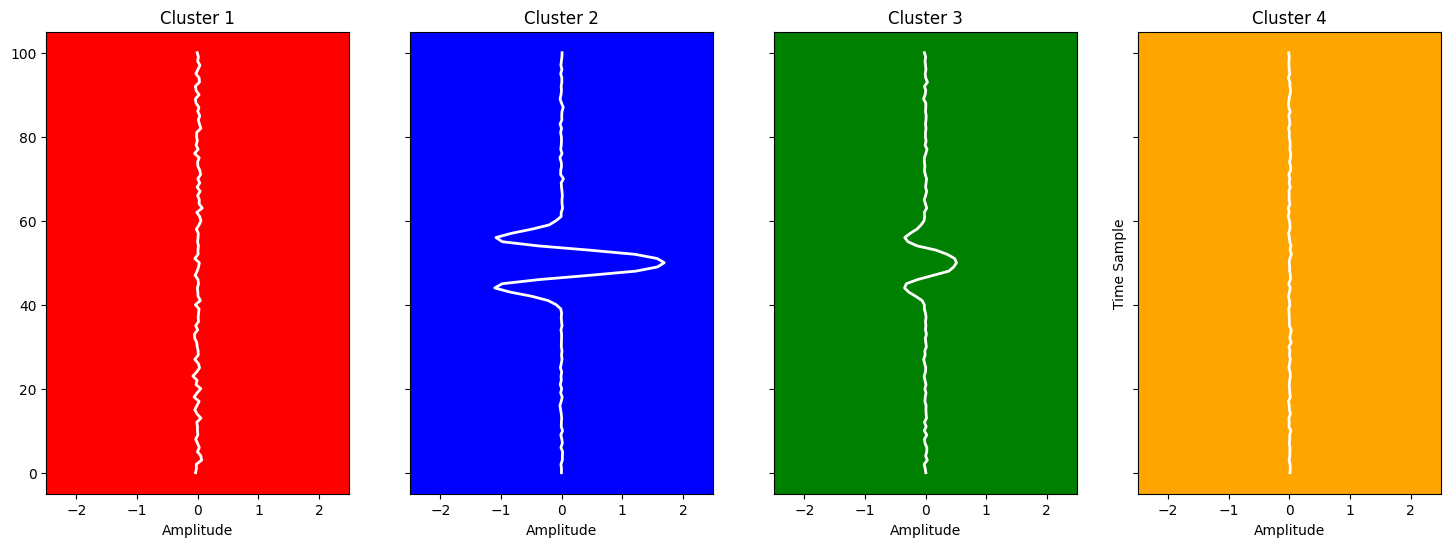

In [ ]:
# Cluster-specific average waveforms
unique_clusters = np.unique(cluster_labels)
fig, axs = plt.subplots(1, num_clusters, figsize=(18, 6), sharey=True)

for i, cluster in enumerate(unique_clusters):
    # Extract traces belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_traces = synth_seismic_noisy_flat[cluster_indices, :]

    # Compute the average waveform for the cluster
    average_waveform = np.mean(cluster_traces, axis=0)

    # Plot the average waveform
    axs[i].plot(average_waveform, np.arange(len(average_waveform)), color="white", lw=2)
    axs[i].set_facecolor(['red', 'blue', 'green', 'orange'][cluster])  # Background color per cluster
    axs[i].set_xlim([-2.5, 2.5])
    axs[i].set_title(f"Cluster {cluster + 1}", fontsize=12)
    axs[i].set_xlabel("Amplitude", fontsize=10)

plt.ylabel("Time Sample", fontsize=10)
plt.show()